In [1]:
# !pip install fastparquet

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
# importing keras layers for cnn
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
# splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Loading data

In [2]:
for dirname, _, filenames in os.walk('quarks_gluons_datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

quarks_gluons_datasets\QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
quarks_gluons_datasets\QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
quarks_gluons_datasets\QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet


In [3]:
filename='quarks_gluons_datasets\QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
parquet_0=pq.ParquetFile(filename)

In [ ]:
# filename='quarks_gluons_datasets/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
# parquet_1=pq.ParquetFile(filename)

In [ ]:
# filename='quarks_gluons_datasets/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
# parquet_3=pd.read_parquet(filename, engine='pyarrow')

### Visualizing X_jets data of 3 channels

In [4]:
df=[]
for i in range(16):
    x=parquet_0.read_row_group(i).to_pandas()
    df.append(x)
df=pd.concat(df,ignore_index=True)
df.head()

,X_jets,pt,m0,y
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",112.411095,21.098248,0.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",95.220406,14.030600,1.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",97.007317,17.728968,1.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",82.490311,14.702741,0.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328483...",102.539238,19.456257,0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


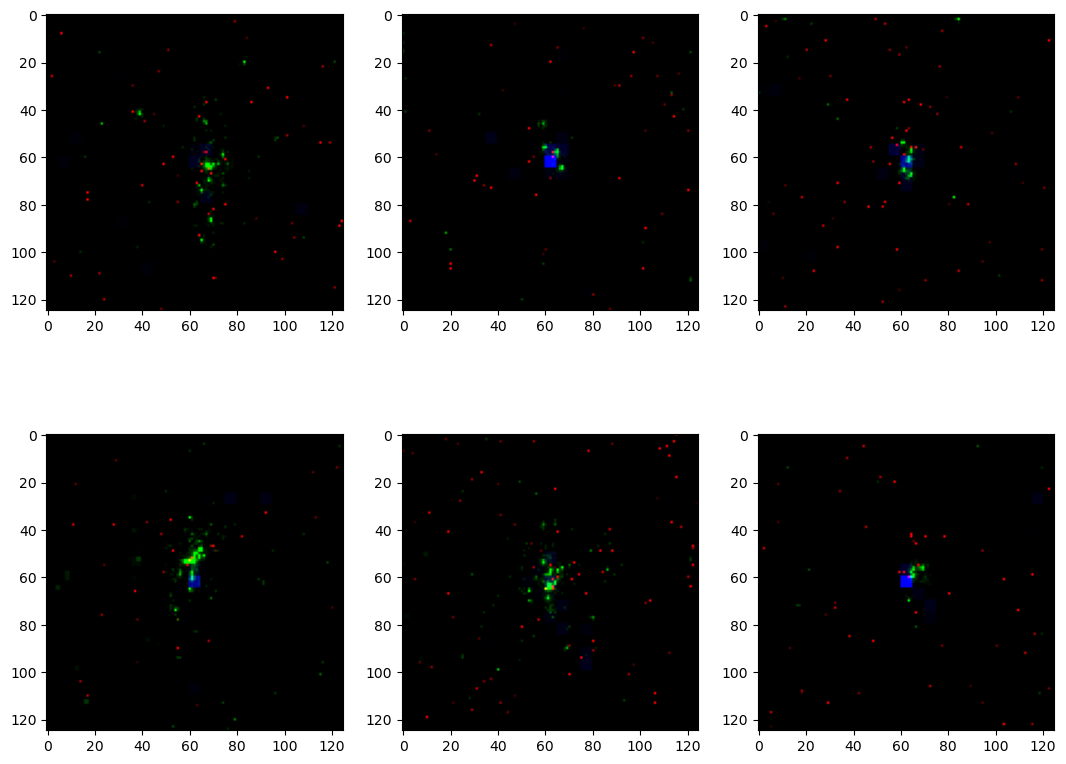

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(13,10))
# fig.suptitle('Sample Datasets')
for i,ax in enumerate(axes.flatten()):
    a=np.array(df['X_jets'][i])
    farr=[]
    for i in range (0,3):
        arr=np.stack(a[i],axis=1)
        farr.append(arr)
    farr=np.array(farr)
    farr_transpose= np.transpose(farr, (1, 2, 0))
    ax.imshow(farr_transpose)

In [4]:
# parquet_0.read_row_group(36271).to_pandas()
# total_rows=parquet_0.num_row_groups
# batch=100
# total_rows

36272

#### Convert to a pandas dataframe

In [ ]:
dfs=[]
for i in parquet_0.iter_batches(batch_size=500):
    dfs.append(i.to_pandas())

In [ ]:
df=pd.concat(dfs,ignore_index=True)

In [ ]:
df

In [25]:
# a=df['X_jets'][0]
# np.array([np.stack(a[0]),np.stack(a[2]),np.stack(a[0])]).shape

(3, 125, 125)

### Issue

#### Convert X_jets data shape to (125,125,3)

In [ ]:
c=0
df1=[]
for a in df.iloc[10000:20000,0]:
    df1.append(np.array([np.stack(a[0]),np.stack(a[1]),np.stack(a[2])]))

In [7]:
df1=np.array(df1)

In [ ]:
df1.shape

In [9]:
df2=[]
for i in range(10000):
    df2.append(np.transpose(df1[i], (1, 2, 0)))

In [10]:
X=np.array(df2)

In [ ]:
df2.shape

In [11]:
y=df.iloc[:10000,3]

## Prepare the Model

In [ ]:
model=models.Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(125,125,3)))
model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

### Loss function and Optimizer

In [13]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

### Training the Model

In [15]:
model.fit(X,y,batch_size=50,epochs=4,verbose=1)

Epoch 1/4
200/200 [==============================] - 247s 1s/step - loss: 0.6500 - accuracy: 0.6661
Epoch 2/4
200/200 [==============================] - 147s 737ms/step - loss: 0.5857 - accuracy: 0.7140
Epoch 3/4
200/200 [==============================] - 147s 734ms/step - loss: 0.5856 - accuracy: 0.7120
Epoch 4/4
200/200 [==============================] - 141s 706ms/step - loss: 0.5547 - accuracy: 0.7242


### Save Model in local Storage

In [12]:
from tensorflow.keras.models import load_model

In [16]:
model.save(os.path.join('models','quarksgulonsModel.h5'))

#### Reload the saved Model

In [15]:
new_model= load_model(os.path.join('models','quarksgulonsmodel.h5'))

### Test the Model

In [ ]:
y_pred=new_model.predict(X)

In [ ]:
model.evaluate(X,y)

In [ ]:
roc_auc_score(y,y_pred)

In [ ]:
fpr, tpr, _ = roc_curve(y,  y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc_score))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Creating KNN with m0 ant pt parameters

In [ ]:
df.isnull().sum()

In [ ]:
df.iloc[:,1:3].duplicated().sum()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Kmodel=KNeighborsClassifier(metric='euclidean')

In [ ]:
Kmodel.fit(X,y)

In [ ]:
y_pred=Kmodel.predict(X)
y_pred

In [ ]:
roc_auc_score(y_pred,y)